In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools

In [2]:
def show_tensor_images(image_tensor,num_images=25,size=(1,28,28),nrow=5,show=True):
    image_tensor=(image_tensor+1)/2
    image_unflat=image_tensor.detach().cpu()
    image_grid=make_grid(image_unflat[:num_images],nrow=nrow)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    if show:
        plt.show()
        

In [3]:
class Generator(nn.Module):
    
    def __init__(self,input_dim=10,im_chan=1,hidden_dim=64):
        super(Generator,self).__init__()
        self.input_dim=input_dim
        self.gen=nn.Sequential(
            self.make_gen_block(input_dim,hidden_dim*4),
            self.make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            self.make_gen_block(hidden_dim*2,hidden_dim),
            self.make_gen_block(hidden_dim,im_chan,kernel_size=4,final_layer=True)
        
        )
    def make_gen_block(self,input_channels,output_channels,kernel_size=3,stride=2,final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
            nn.Tanh(),
            )
        
    def forward(self,x):
        x=x.view(len(x),self.input_dim,1,1)
        return self.gen(x)
    
        

In [4]:
def get_noise(n_samples,input_dim,device='cpu'):
    return torch.randn(n_samples,input_dim,device=device)

In [5]:
import torch.nn.functional as F

In [6]:
def get_c_noise(n_samples,input_dim,device='cpu'):
    K=10
    cat_c=torch.randint(0,K,size=(n_samples,input_dim),device=device)
    return cat_c

In [60]:
get_noise(5,2,device='cuda')

tensor([[ 0.5985,  1.2321],
        [-1.7844,  0.8146],
        [-1.0826, -0.5119],
        [-1.1746, -0.3656],
        [ 1.2480, -1.7604]], device='cuda:0')

In [8]:
class Discriminator(nn.Module):
    def __init__(self,im_chan=1,hidden_dim=64,c_dim=10):
        super(Discriminator,self).__init__()
        self.disc=nn.Sequential(
        self.make_disc_block(im_chan,hidden_dim),
            self.make_disc_block(hidden_dim,hidden_dim*2),
        )
        self.d_layer=self.make_disc_block(hidden_dim*2,1,final_layer=True)
        self.q_layer=nn.Sequential(
        self.make_disc_block(hidden_dim*2,hidden_dim*2),
        self.make_disc_block(hidden_dim*2,K*c_dim,kernel_size=1,final_layer=True)
#         ,nn.Softmax(dim=-1)
        )
        
    def make_disc_block(self,input_channels,output_channels,kernel_size=4,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
    def forward(self,image):
        intermediate_pred=self.disc(image)
        disc_pred=self.d_layer(intermediate_pred)
        q_pred=self.q_layer(intermediate_pred)
        
        return disc_pred.view(len(disc_pred), -1), q_pred.view(len(q_pred), -1)
        

In [9]:
def combine_vector(x,y):
    return torch.cat([x.float(),y.float()],1)

In [10]:
torch.tensor([1/10]).repeat(5)

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000])

In [11]:
from torch.distributions.categorical import Categorical
adv_criterion=nn.BCEWithLogitsLoss()
K=10
# c_criterion=lambda c_true,K: Categorical(probs=K).log_prob(c_true).mean()
c_criterion=nn.CrossEntropyLoss()
c_lambda=1
mnist_shape=(1,28,28)
n_epochs=80
z_dim=64
c_dim=1
display_step=500
batch_size=128
d_lr=2e-4
g_lr=1e-3
device='cuda'
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])

dataloader=DataLoader(
MNIST("P:\\dataset\\",transform=transform),
batch_size=batch_size,
    shuffle=True
)

In [12]:
gen=Generator(input_dim=z_dim+c_dim*K).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=g_lr)
disc=Discriminator(im_chan=mnist_shape[0],c_dim=c_dim*K).to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=d_lr)
info_opt=torch.optim.Adam(itertools.chain(gen.parameters(),disc.parameters()))
def weigts_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
        torch.nn.init.constant_(m.bias,0)


gen=gen.apply(weigts_init)
disc=disc.apply(weigts_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.8099375545978547, discriminator loss: 0.6383357111215592


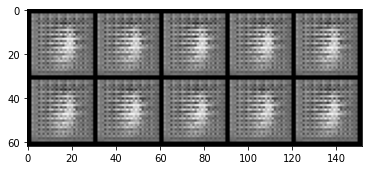

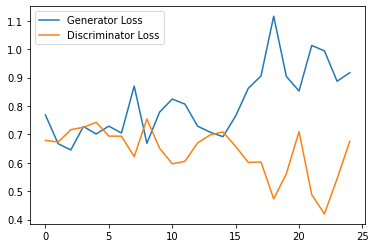

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 1.0991809772253036, discriminator loss: 0.4941266664862633


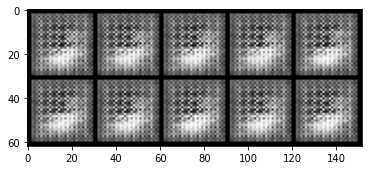

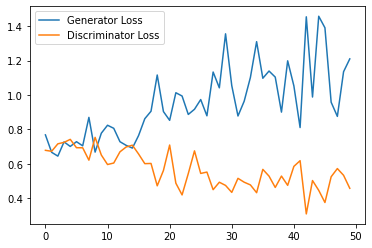

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 1.279287098288536, discriminator loss: 0.4449816799759865


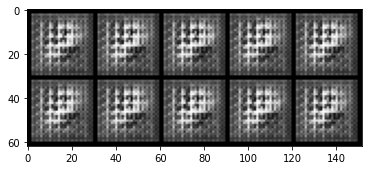

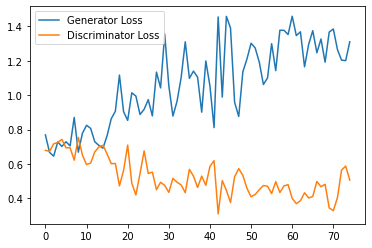

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 1.197481710255146, discriminator loss: 0.5145390713810921


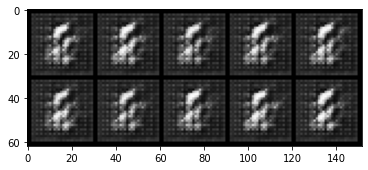

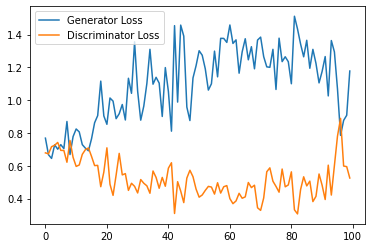

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 0.865892076075077, discriminator loss: 0.6651311321854592


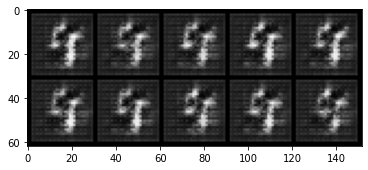

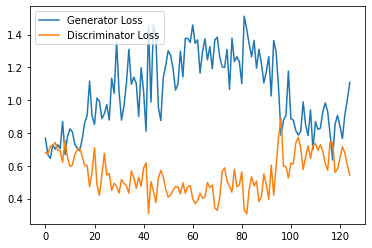

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 0.7911772867441177, discriminator loss: 0.6813593343496323


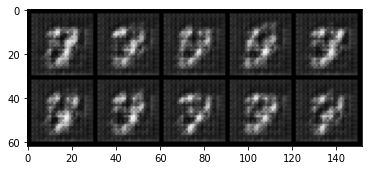

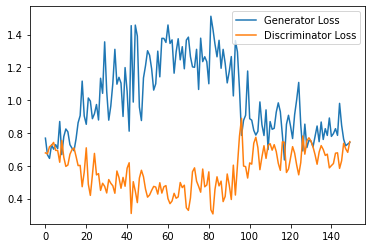

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 0.7931874558925629, discriminator loss: 0.6782136093378067


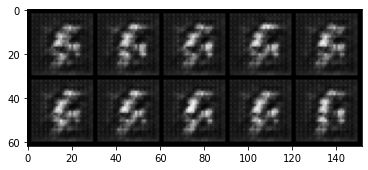

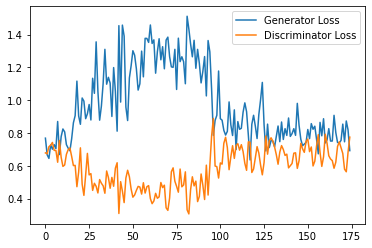

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 0.8389811795949936, discriminator loss: 0.6334611041545868


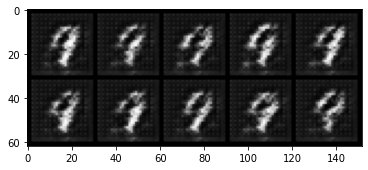

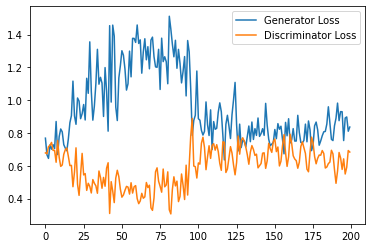

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 0.768940777540207, discriminator loss: 0.6697089817523957


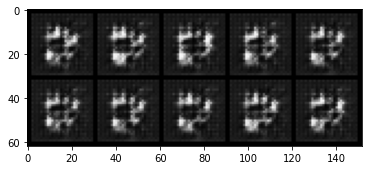

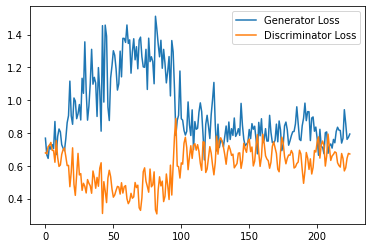

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 0.8383697924613953, discriminator loss: 0.6279743893146514


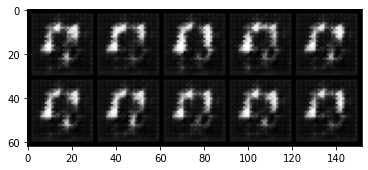

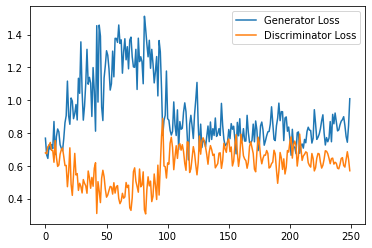

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 0.8803639515638352, discriminator loss: 0.6118009209036827


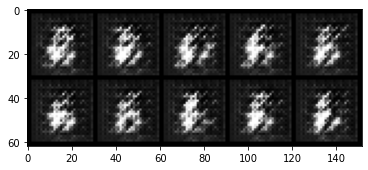

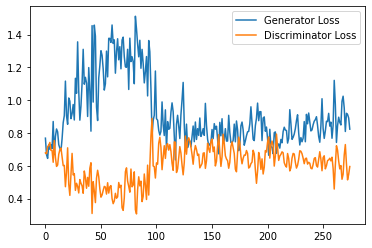

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 0.8484238340854645, discriminator loss: 0.6202706360816955


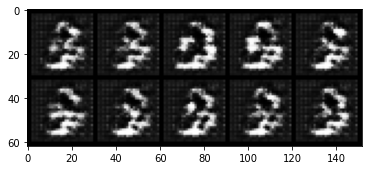

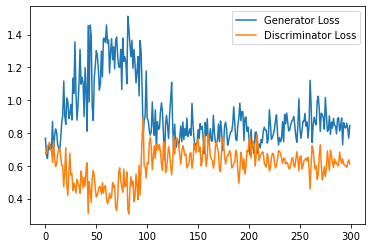

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 0.850705074429512, discriminator loss: 0.6249192521572113


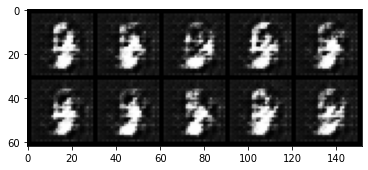

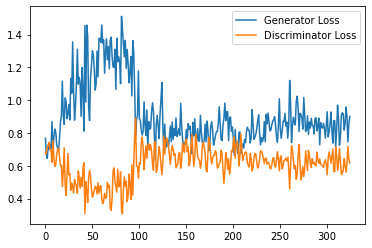

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 0.8542938199043274, discriminator loss: 0.6095450115203858


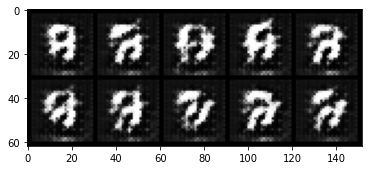

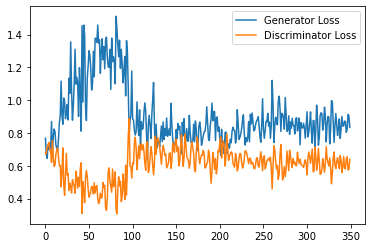

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 0.8578618423938751, discriminator loss: 0.6123899246454239


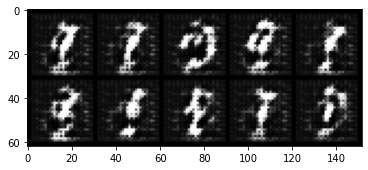

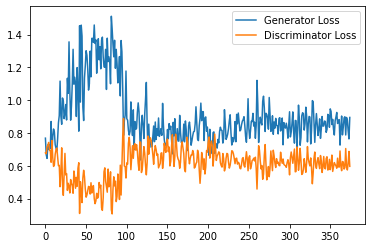

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 0.8671995177268982, discriminator loss: 0.6022401884794235


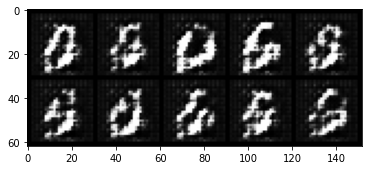

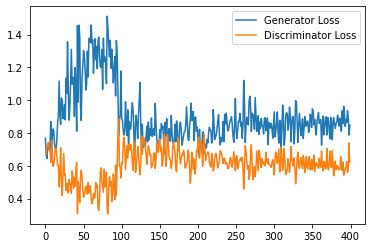

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 0.8898472697734833, discriminator loss: 0.6025463043451309


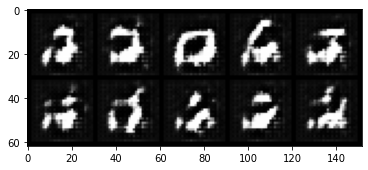

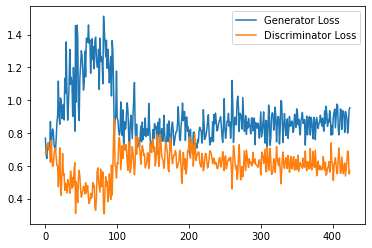

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 0.9005881088972092, discriminator loss: 0.598377894103527


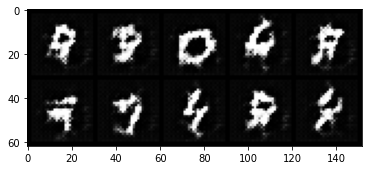

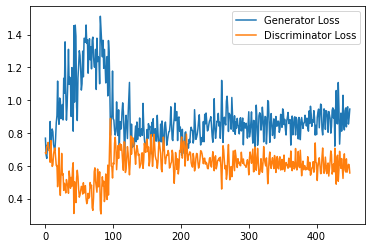

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 0.8700255861282349, discriminator loss: 0.5993313015699386


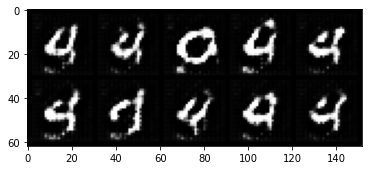

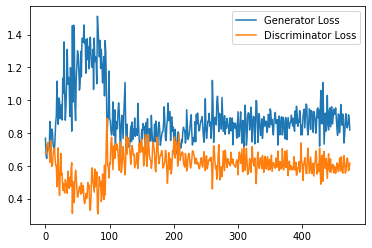

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 0.8490301719903945, discriminator loss: 0.6114807140827179


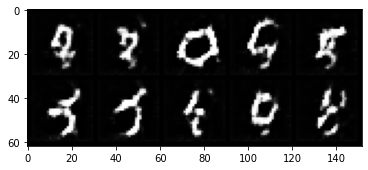

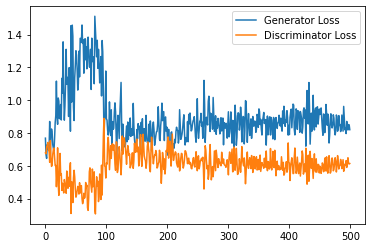

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 0.8380375425815583, discriminator loss: 0.627012568950653


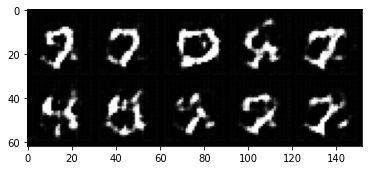

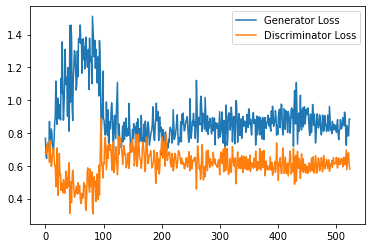

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 0.8255930655002593, discriminator loss: 0.630367798924446


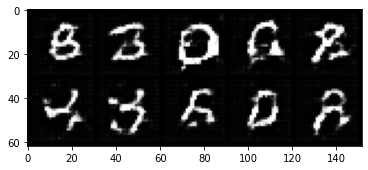

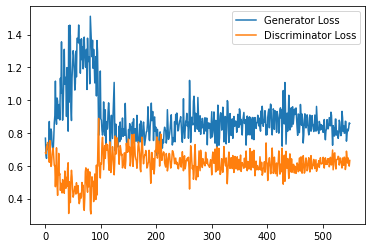

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 0.8160657602548599, discriminator loss: 0.6404783645868302


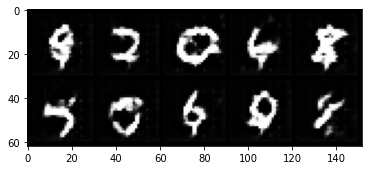

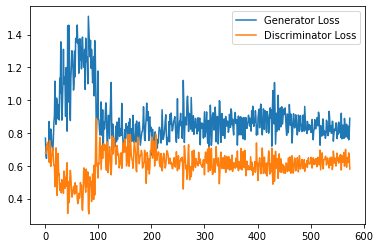

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 0.8164320904016494, discriminator loss: 0.6509005272984505


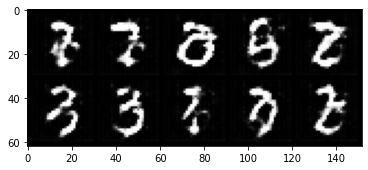

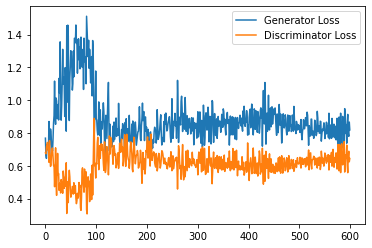

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 0.8146007813215256, discriminator loss: 0.6412525725364685


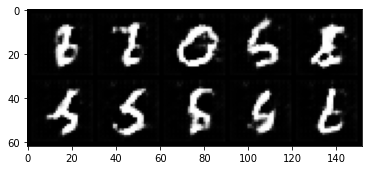

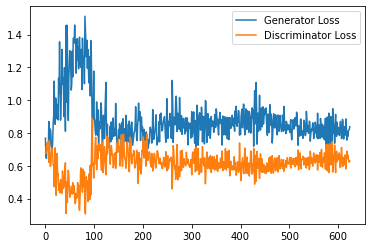

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 0.7822128133773804, discriminator loss: 0.6543267127275467


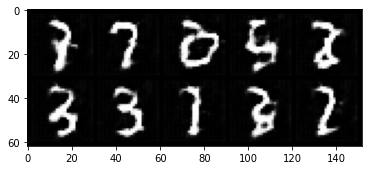

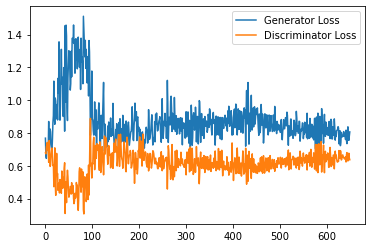

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 0.7778956760168075, discriminator loss: 0.667045100569725


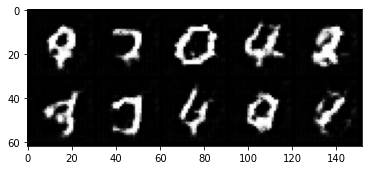

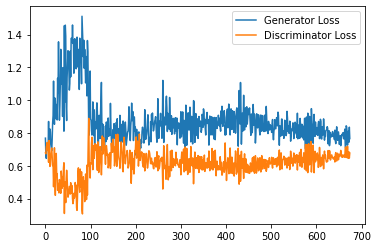

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 0.7886639432907104, discriminator loss: 0.6600256640911102


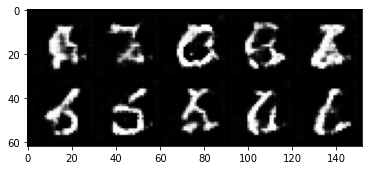

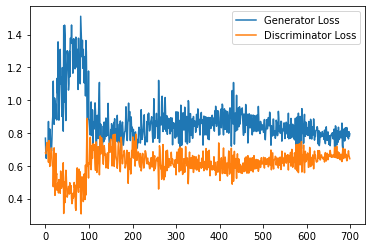

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 0.7624859968423844, discriminator loss: 0.6730449723005295


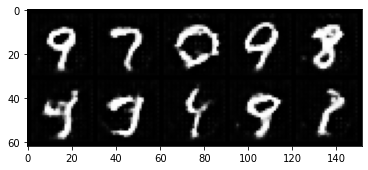

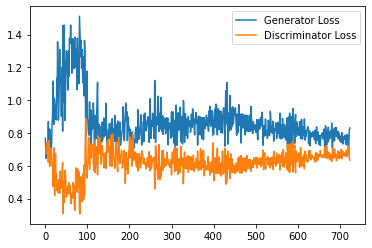

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 0.7862706289291382, discriminator loss: 0.6795735292434693


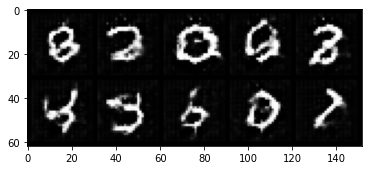

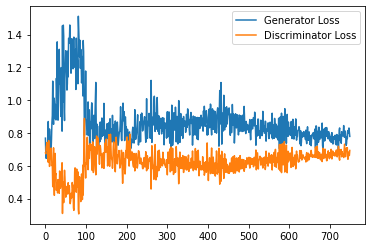

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 0.7640015941858291, discriminator loss: 0.6827220239639282


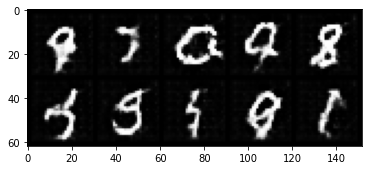

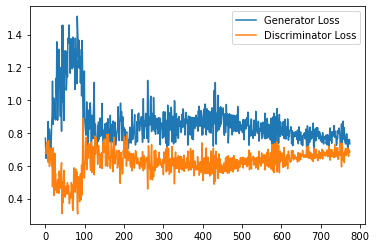

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 0.7707422674894333, discriminator loss: 0.6703071493506432


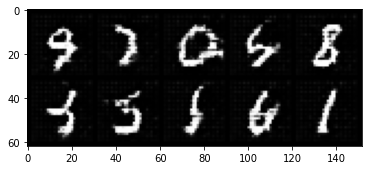

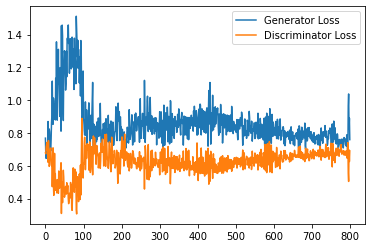

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 0.7717650656700135, discriminator loss: 0.6741293520927429


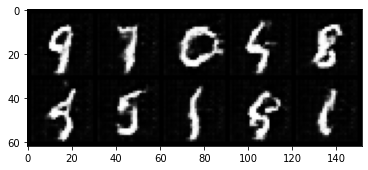

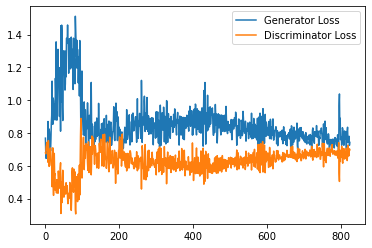

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 0.7548843168020248, discriminator loss: 0.6870243085622787


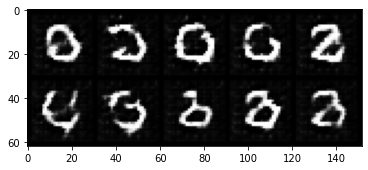

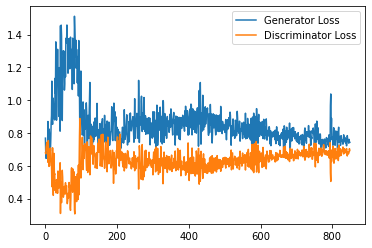

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 0.7527181491851807, discriminator loss: 0.6861177772283554


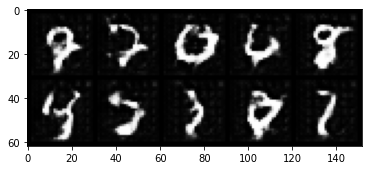

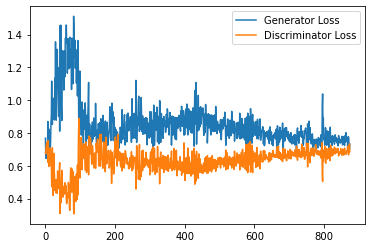

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 0.7438865998983383, discriminator loss: 0.683704858660698


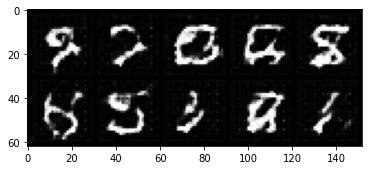

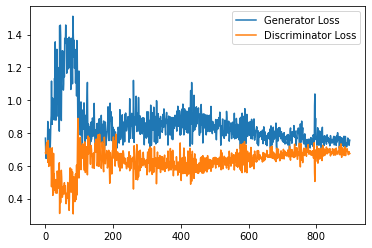

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 0.7435123850107193, discriminator loss: 0.6884858051538467


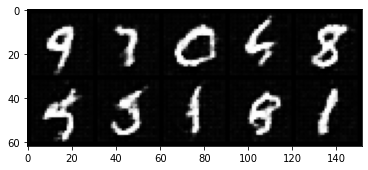

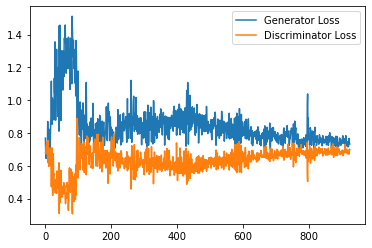

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 0.7347014294862747, discriminator loss: 0.6865966305732727


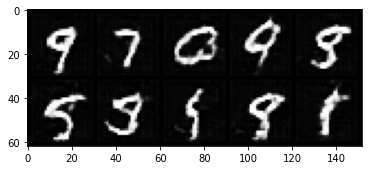

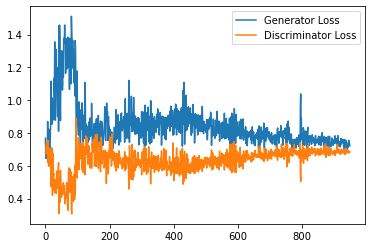

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 0.7406699540615082, discriminator loss: 0.6844053738117218


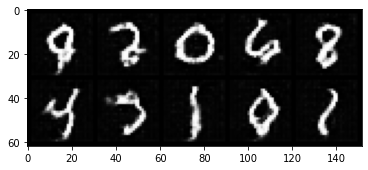

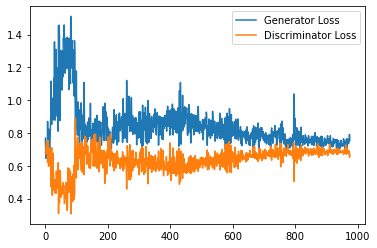

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 0.7536165248155594, discriminator loss: 0.6861135147809982


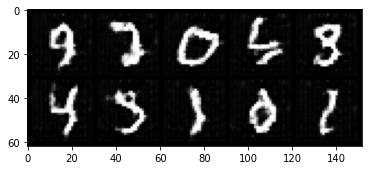

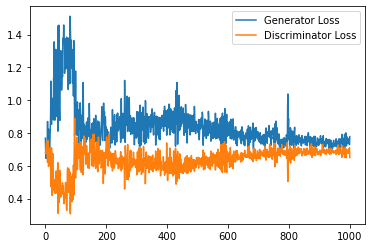

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 0.7475616706609726, discriminator loss: 0.6831599320173264


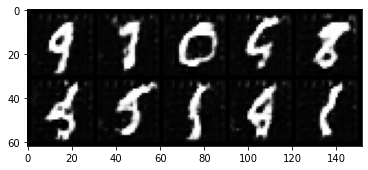

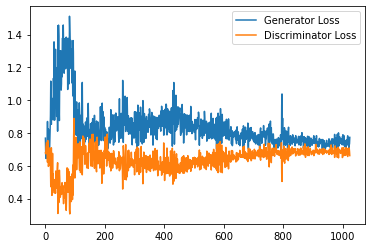

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 0.7491045078039169, discriminator loss: 0.6852827734947204


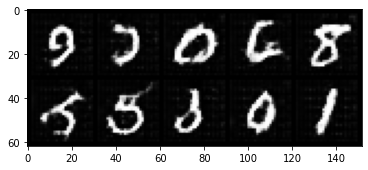

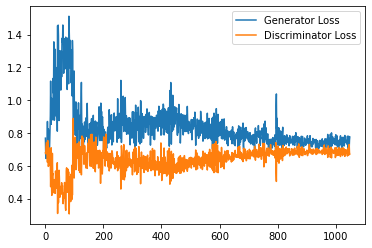

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 0.7458119704723358, discriminator loss: 0.6868035254478455


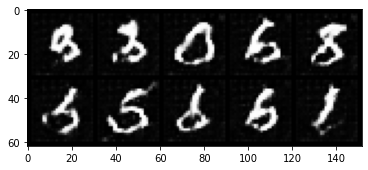

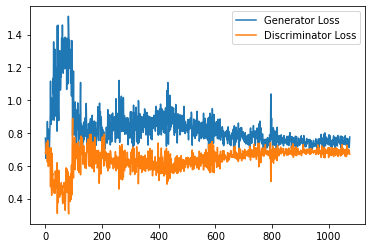

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 0.7378979384899139, discriminator loss: 0.6856512820720673


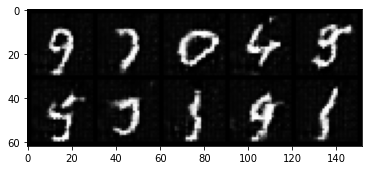

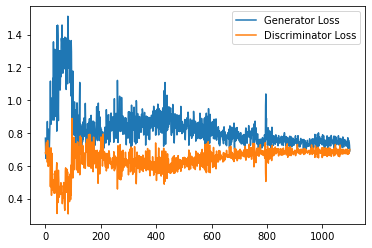

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 0.7368296432495117, discriminator loss: 0.6862621997594833


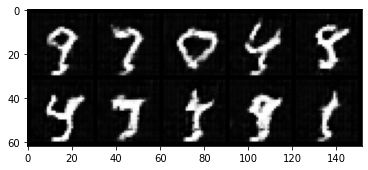

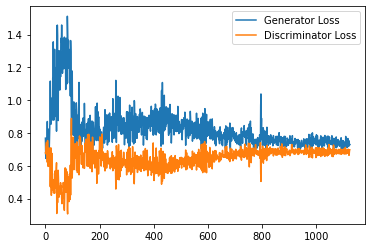

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 0.7402984730005264, discriminator loss: 0.6839261531829834


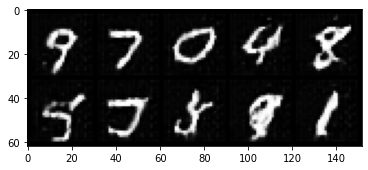

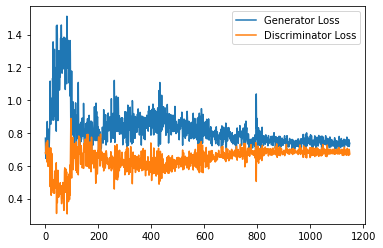

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50, step 23500: Generator loss: 0.7393237100839615, discriminator loss: 0.6880275105237961


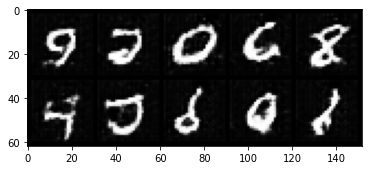

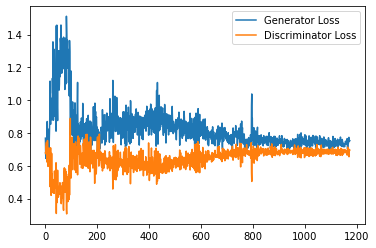

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51, step 24000: Generator loss: 0.7408794478178025, discriminator loss: 0.6845480097532273


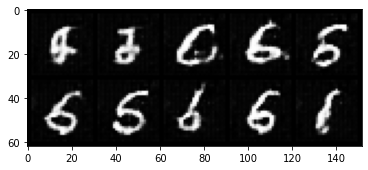

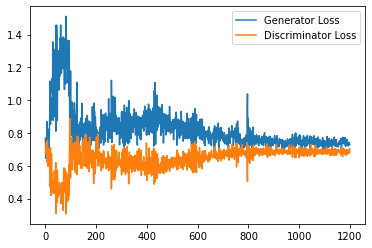

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52, step 24500: Generator loss: 0.731236300110817, discriminator loss: 0.6903420717716217


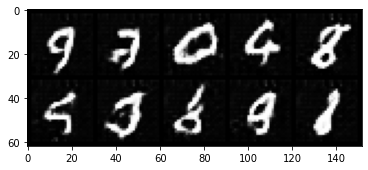

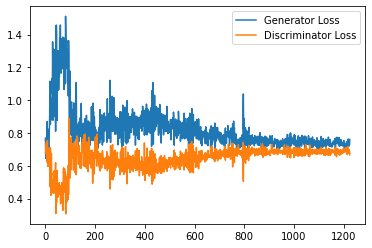

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53, step 25000: Generator loss: 0.7354488018751144, discriminator loss: 0.6912734299898148


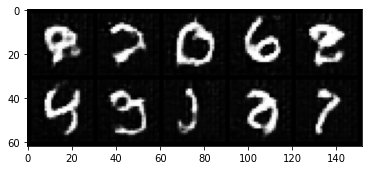

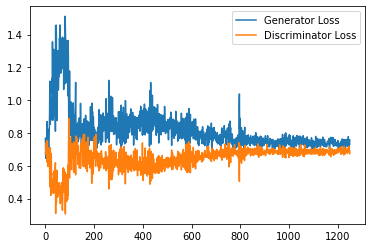

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54, step 25500: Generator loss: 0.7307448145151139, discriminator loss: 0.6909149049520492


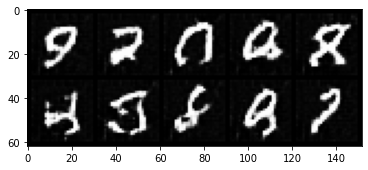

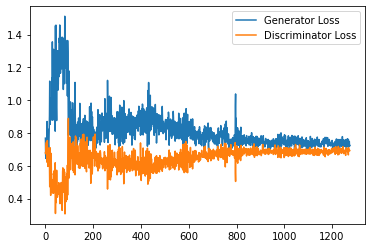

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55, step 26000: Generator loss: 0.7328538271188736, discriminator loss: 0.6879329581260681


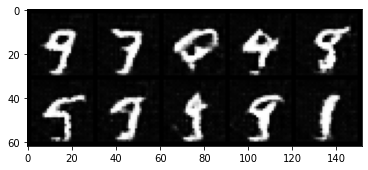

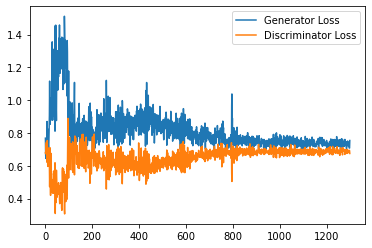

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56, step 26500: Generator loss: 0.7244893703460693, discriminator loss: 0.689681466460228


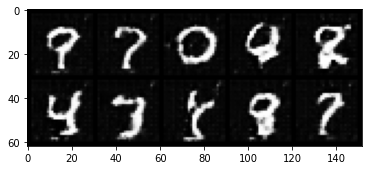

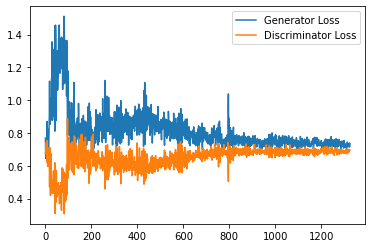

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57, step 27000: Generator loss: 0.7310021195411682, discriminator loss: 0.6924553822278976


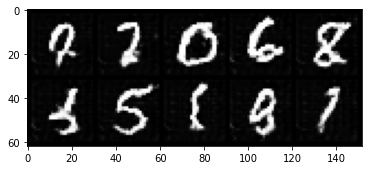

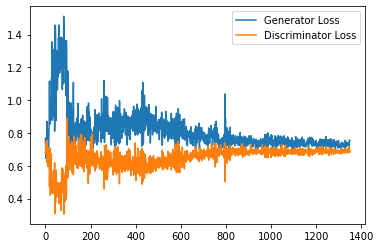

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58, step 27500: Generator loss: 0.7333326878547668, discriminator loss: 0.6885784265995025


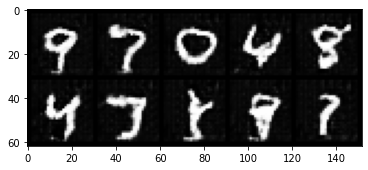

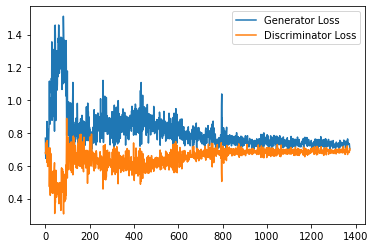

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59, step 28000: Generator loss: 0.7304022723436355, discriminator loss: 0.6867160894870759


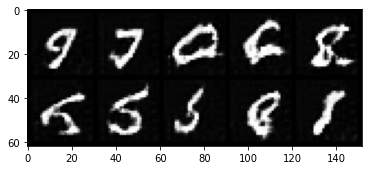

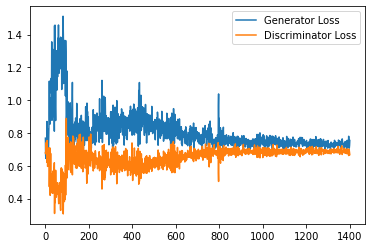

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60, step 28500: Generator loss: 0.7395365308523179, discriminator loss: 0.6876105360984802


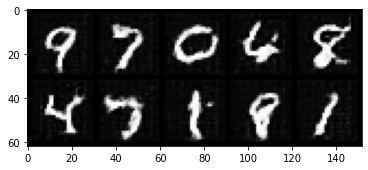

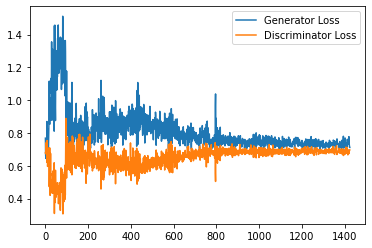

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61, step 29000: Generator loss: 0.7356790126562118, discriminator loss: 0.6912701387405396


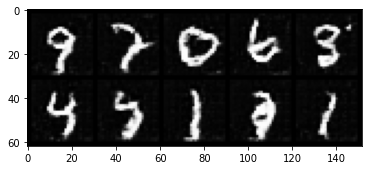

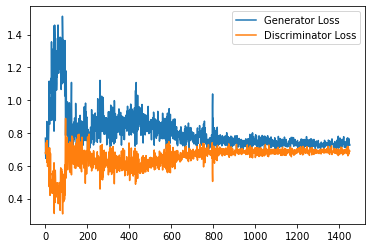

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62, step 29500: Generator loss: 0.7167911245822907, discriminator loss: 0.6904657709598542


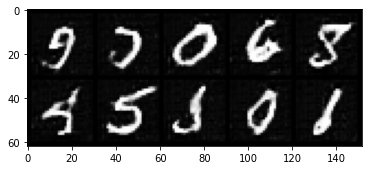

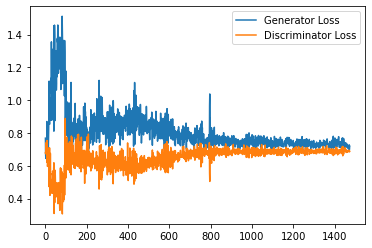

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63, step 30000: Generator loss: 0.7134356981515885, discriminator loss: 0.6922852698564529


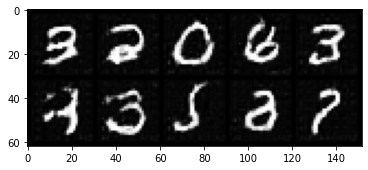

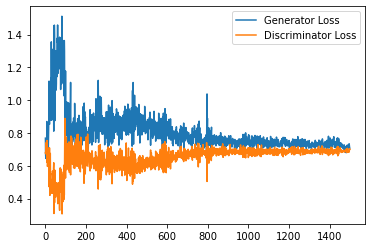

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65, step 30500: Generator loss: 0.7302828919887543, discriminator loss: 0.6892817738056183


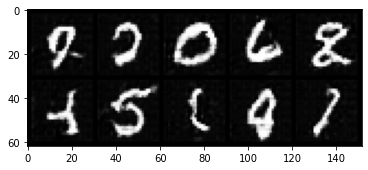

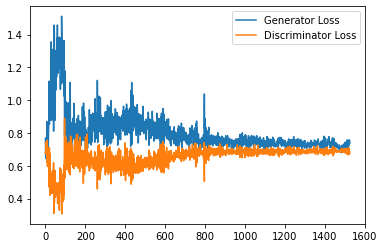

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66, step 31000: Generator loss: 0.7459585794210434, discriminator loss: 0.6885510604381562


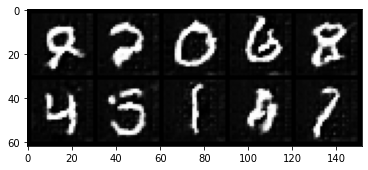

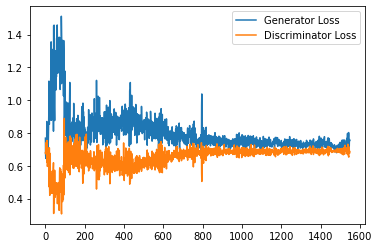

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67, step 31500: Generator loss: 0.7539504709243774, discriminator loss: 0.6823267829418183


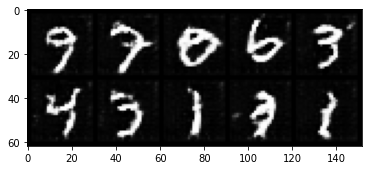

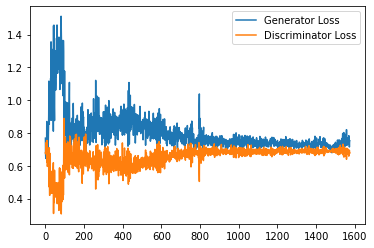

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68, step 32000: Generator loss: 0.7297285817861557, discriminator loss: 0.687064091205597


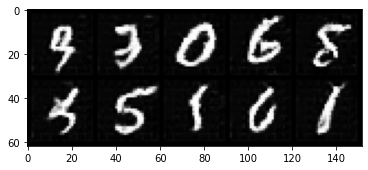

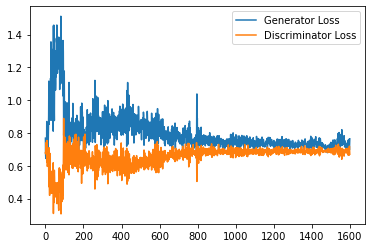

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69, step 32500: Generator loss: 0.7413164423704147, discriminator loss: 0.6846334851980209


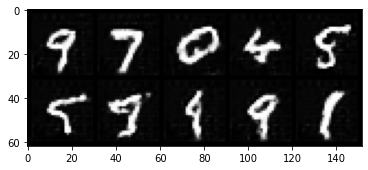

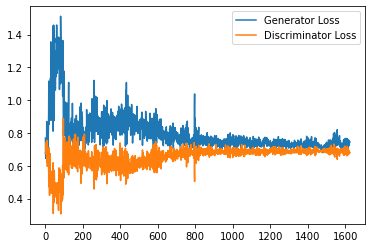

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70, step 33000: Generator loss: 0.7206341265439987, discriminator loss: 0.6939209501743316


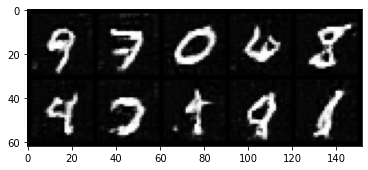

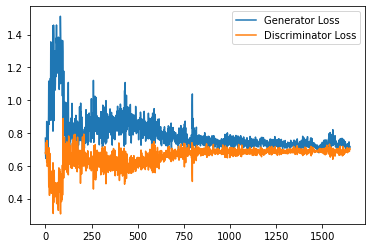

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71, step 33500: Generator loss: 0.7222906587123871, discriminator loss: 0.6912609099149704


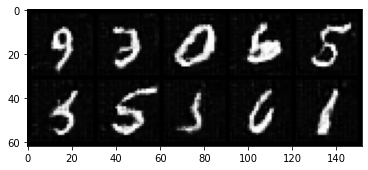

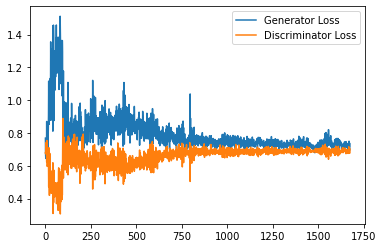

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72, step 34000: Generator loss: 0.7189185310602189, discriminator loss: 0.6912821877002716


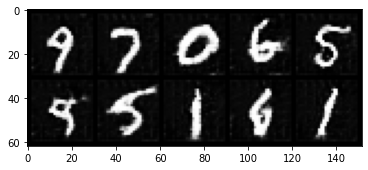

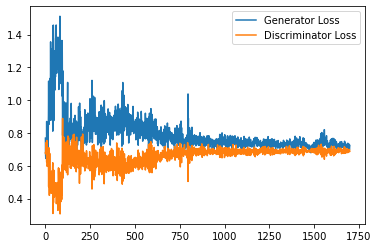

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 73, step 34500: Generator loss: 0.7118828617334366, discriminator loss: 0.6948869956731796


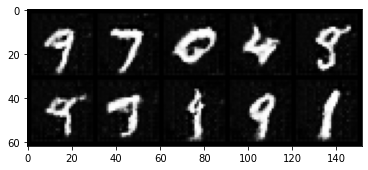

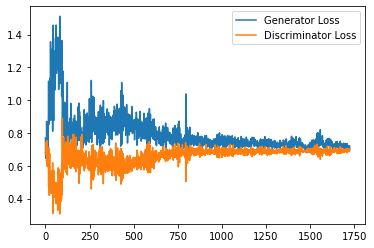

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 74, step 35000: Generator loss: 0.7196532683372497, discriminator loss: 0.6984835166931153


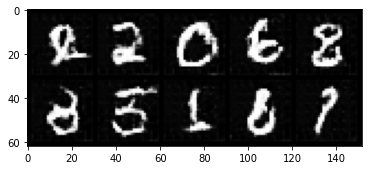

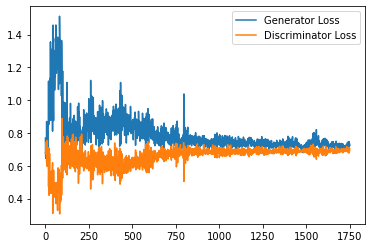

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 75, step 35500: Generator loss: 0.7304951025247574, discriminator loss: 0.6934842005968094


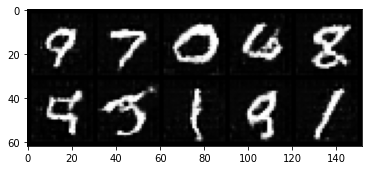

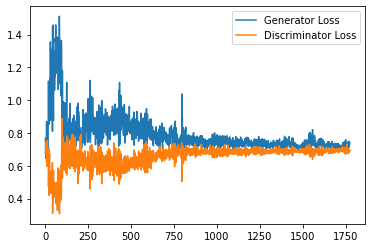

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 76, step 36000: Generator loss: 0.7212942101955414, discriminator loss: 0.6927010288238525


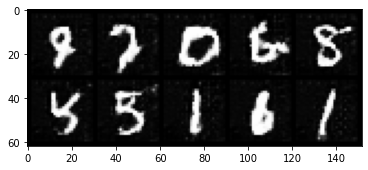

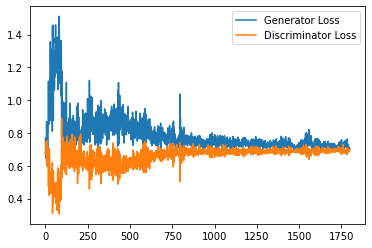

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 77, step 36500: Generator loss: 0.7141621090173721, discriminator loss: 0.6932463836669922


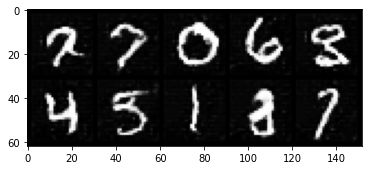

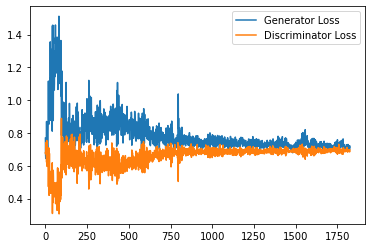

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 78, step 37000: Generator loss: 0.7147363175153733, discriminator loss: 0.6954178464412689


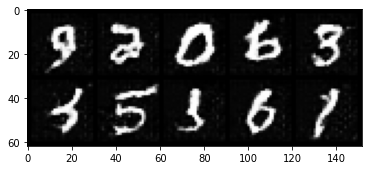

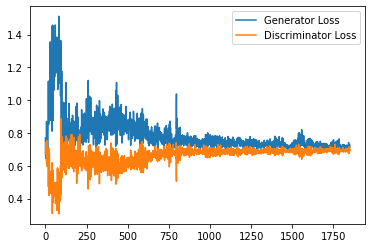

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 79, step 37500: Generator loss: 0.721529497385025, discriminator loss: 0.6924599568843841


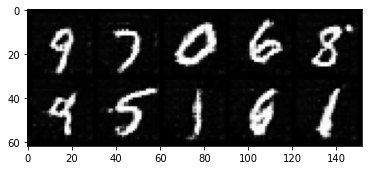

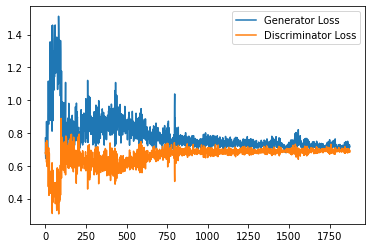

In [14]:
cur_step=0
generator_losses=[]
discriminator_losses=[]

for epoch in range(n_epochs):
    for real,_ in tqdm(dataloader):
        cur_batch_size=len(real)
        real=real.to(device)
        
        c_labels=get_c_noise(cur_batch_size,c_dim,device=device).squeeze(dim=-1)
#         print(c_labels.shape)
        c_lable_one_hot=F.one_hot(c_labels,num_classes=K)
#         print(c_lable_one_hot.shape)
        c_lable_one_hot=c_lable_one_hot.squeeze(dim=1)
        disc_opt.zero_grad()
        fake_noise=get_noise(cur_batch_size,z_dim,device=device)
        noise_and_c=combine_vector(fake_noise,c_lable_one_hot)
#         print(noise_and_c.shape)
        fake=gen(noise_and_c)
        disc_fake_pred,disc_q_pred=disc(fake.detach())
#         print(disc_q_pred[:,0].shape)
#         disc_q_mean=disc_q_pred[:,:c_dim]
#         disc_q_logvar=disc_q_pred[:,c_dim:]
       
#         print(c_labels.size())
#         mutual_information=c_criterion(disc_q_pred,c_labels)
        
        disc_real_pred,_=disc(real)
        disc_fake_loss=adv_criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_loss=adv_criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        
        disc_loss=(disc_real_loss+disc_fake_loss)/2# - c_lambda*mutual_information
        disc_loss.backward(retain_graph=True)
        
        disc_opt.step()
        
        discriminator_losses+=[disc_loss.item()]
        
        
        gen_opt.zero_grad()
        disc_fake_pred,disc_q_pred=disc(fake)
        
#         disc_q_mean=disc_q_pred[:,:c_dim]
#         disc_q_logvar=disc_q_pred[:,c_dim:]
        
#         mutual_information=c_criterion(disc_q_pred,c_labels)
        gen_loss=adv_criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))#-c_lambda*mutual_information
        gen_loss.backward()
        gen_opt.step()
        generator_losses += [gen_loss.item()]
        
        c_labels=get_c_noise(cur_batch_size,c_dim,device=device).squeeze(dim=-1)
        c_lable_one_hot=F.one_hot(c_labels,num_classes=K)
        c_lable_one_hot=c_lable_one_hot.squeeze(dim=1)
        info_opt.zero_grad()
        fake_noise=get_noise(cur_batch_size,z_dim,device=device)
        noise_and_c=combine_vector(fake_noise,c_lable_one_hot)
        fake=gen(noise_and_c)
        disc_fake_pred,disc_q_pred=disc(fake)
        mutal_info_loss=c_lambda*c_criterion(disc_q_pred,c_labels)
        mutal_info_loss.backward()
        info_opt.step()

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            with torch.no_grad():
                
                fake_noise=get_noise(1,z_dim,device=device)
                batch=10
                c_labels=torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]],device=device)
                c_one_hot=F.one_hot(c_labels,num_classes=K).squeeze(dim=1)


                fake_noise= torch.cat(batch*[fake_noise])

                noise_and_c=combine_vector(fake_noise,c_one_hot)
           
                images=gen(noise_and_c)
                show_tensor_images(images)
#             show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1



In [ ]:
c_labels.shape

In [ ]:
gen=gen.eval()

In [69]:
fake_noise=get_noise(1,z_dim,device=device)

torch.Size([100, 10])
torch.Size([101, 64]) torch.Size([100, 10])


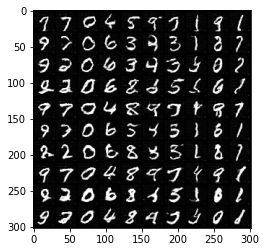

In [70]:

batch=10
# c_labels=get_c_noise(batch,c_dim,device=device)
c_labels=torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]],device=device)
c_labels=torch.cat(batch*[c_labels])
# print(c_labels)
c_one_hot=F.one_hot(c_labels,num_classes=K).squeeze(dim=1)
print(c_one_hot.shape)
# print(c_labels.view(-1))
for _ in range(batch):
    fake_noise_set=get_noise(1,z_dim,device=device)
    fake_noise_set= torch.cat(batch*[fake_noise_set])
    fake_noise=torch.cat([fake_noise,fake_noise_set])
print(fake_noise.shape,c_one_hot.shape)
noise_and_c=combine_vector(fake_noise[1:],c_one_hot)
# print(noise_and_c)
images=gen(noise_and_c)



show_tensor_images(images,num_images=100,nrow=10)


In [44]:
noise_and_c.shape

torch.Size([10, 74])

In [22]:
import numpy as np

In [26]:
def c_dist(m,c_dim):
    return np.random.multinomial(1,c_dim*[1/c_dim],size=m)

In [27]:
c_dist(2,10)

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

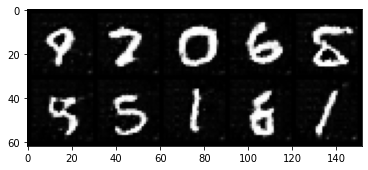

In [59]:
with torch.no_grad():
                
                fake_noise=get_noise(1,z_dim,device=device)
                batch=10
                c_labels=torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]],device=device)
                c_one_hot=F.one_hot(c_labels,num_classes=K).squeeze(dim=1)


                fake_noise= torch.cat(batch*[fake_noise])

                noise_and_c=combine_vector(fake_noise,c_one_hot)
           
                images=gen(noise_and_c)
                show_tensor_images(images)